In [36]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [37]:
# Read in dataset
df = pd.read_csv(r"C:\Users\adeel\Downloads\parkinson_disease.csv")
pd.set_option('display.max_columns', 10)
df.head()

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,...,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,...,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,...,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,...,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,...,11.6891,8.2103,5.0559,6.1164,1


In [3]:
# Determine if data needs to be cleaned
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


In [5]:
df.isnull().sum().sum()

np.int64(0)

In [38]:
# No need for data cleaning since there are no null values

# Data Wrangling
# Aggregate patient id to create one record per patient
df = df.groupby('id').mean().reset_index()
df.drop('id', axis = 1, inplace = True)

In [39]:
# Remove highly correlated features
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
            # If the correlation between the two features is more than 0.7, remove it
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
            
    df = df[filtered_columns]
df.shape

(252, 287)

In [40]:
# Reduced the dataset from 755 features to 252, however, this is till high

# Chi-squared test to further reduce features
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

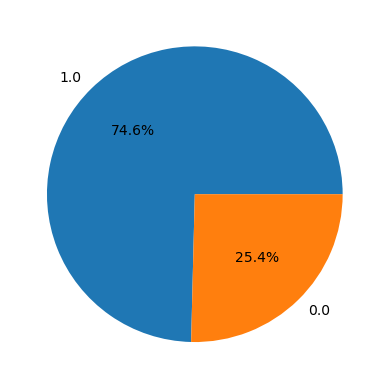

In [41]:
# Reduced to 30 most important features based on their relationship with 'class'

# Pie chart to check for imbalances
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

In [42]:
# Addressing class imbalances by splitting data into training and test
features = df.drop('class', axis=1)
target = df['class']

X_train, X_test, Y_train, Y_test = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

In [43]:
# Model training and evaluation
from sklearn.metrics import roc_auc_score as ras

models = [LogisticRegression(class_weight='balanced'), XGBClassifier(), SVC(kernel='rbf', probability=True)] 
for model in models:
    model.fit(X, Y)
    print(f'{model} : ')

    train_preds = model.predict(X)
    print('Training Accuracy : ', ras(Y, train_preds))

    val_preds = model.predict(X_test)
    print('Validation Accuracy : ', ras(Y_test, val_preds))
    print()

LogisticRegression(class_weight='balanced') : 
Training Accuracy :  0.7715231788079471
Validation Accuracy :  0.8301158301158301

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.6467181467181468

SVC(probability=True) : 
Training Accu

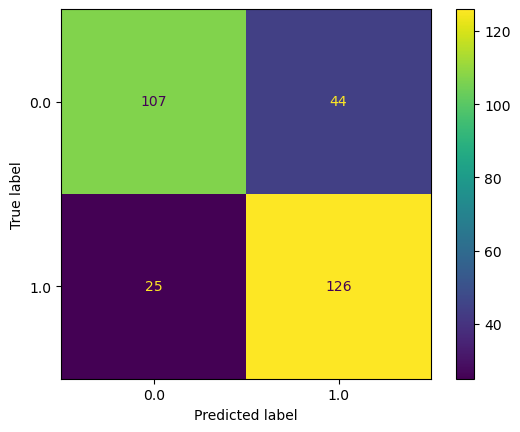

In [44]:
# We see that the logisitic regression classifier is a better fit since there's less difference between training and validation

# Analyze model performance
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X, Y)
plt.show()

In [46]:
# This analysis shows the model correctly classifies most cases but still misclassified 25 healthy individuals

from sklearn.metrics import classification_report
print(classification_report(Y, models[0].predict(X)))

              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76       151
         1.0       0.74      0.83      0.79       151

    accuracy                           0.77       302
   macro avg       0.78      0.77      0.77       302
weighted avg       0.78      0.77      0.77       302



In [ ]:
# The report indicates that the model perfroms well overall but has room for improvement in recall (0.71) 